### Importing GPT2 from Hugging Faces

Details on the model:

In [1]:
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import matplotlib.pyplot as plt
import seaborn as sns


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
vocab = tokenizer.get_vocab()
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True, output_attentions=True)

print("Model name:", model.config.name_or_path)
print("Tokenizer:", tokenizer.name_or_path)
print("Vocabulary size:", tokenizer.vocab_size)
print("Embedding dimensions:", model.config.hidden_size)
print("Number of attention layers:", model.config.num_hidden_layers)

Model name: gpt2
Tokenizer: gpt2
Vocabulary size: 50257
Embedding dimensions: 768
Number of attention layers: 12


In [2]:
embeddings = model.wte.weight.data
print("Initial embedding matrix size:", tuple(embeddings.shape))      # This is the embedding matrix. Each row corresponds to a token in the vocabulary.
embeddings[11]

Initial embedding matrix size: (50257, 768)


tensor([ 1.1497e-02, -2.9490e-03,  3.2314e-02,  5.5183e-02,  5.2392e-02,
        -6.0363e-02, -2.3997e-01, -1.7334e-02,  3.8838e-02,  4.0289e-02,
        -3.2901e-03,  1.9730e-02, -2.1079e-02, -3.7016e-03, -1.9246e-02,
         3.7273e-02, -4.8122e-02, -3.3349e-02,  1.0537e-02,  2.0797e-01,
        -8.2787e-02, -1.0692e-02, -4.8333e-02, -3.7857e-02,  7.9460e-02,
         3.0554e-02, -3.8337e-02,  1.1336e-02, -4.2484e-02, -2.8114e-02,
         4.6458e-02,  6.6223e-04,  1.8305e-02, -7.2216e-02,  3.8865e-02,
         4.0108e-02, -3.1543e-01, -7.5379e-02, -1.5715e-02,  3.2486e-02,
         1.6226e-02,  3.1688e-02, -2.5208e-02, -1.0170e-01, -3.9139e-02,
        -4.1878e-02,  4.5673e-02,  3.7798e-02, -4.8963e-02, -7.3122e-02,
        -4.0856e-02,  5.5752e-02,  6.5839e-02,  4.0031e-02, -2.0230e-02,
        -1.1294e-01, -2.1563e-02, -3.6031e-02,  3.3491e-02, -3.1375e-02,
        -9.6931e-02, -3.3430e-02, -4.8675e-02,  6.8246e-03, -5.6962e-01,
         7.1983e-02, -2.7708e-02, -3.9506e-02,  1.4

In [3]:
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. I was born in 1564 and died in 1642. My name is Galileo Galilei."

# encode the prompt. It will return a dictionary with the input ids and attention mask
encodedPrompt = tokenizer(prompt, return_tensors='pt')   # convert to pytorch tensor
totToken = len(encodedPrompt["input_ids"][0])  
print("Prompt:", prompt)
print("Total tokens in prompt:", totToken)

print("Token that GPT2 will see:", end = ": ")
for tokenId in encodedPrompt["input_ids"][0].numpy():
    #print(tokenizer.convert_ids_to_tokens([tokenId]), end = " ")
    print(tokenizer.decode(tokenId), end = " | ")

Prompt: I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. I was born in 1564 and died in 1642. My name is Galileo Galilei.
Total tokens in prompt: 44
Token that GPT2 will see:: I | 'm |  an |  Italian |  physicist |  who |  lived |  in |  Pad | ua | . |  I |  am |  known |  for |  my |  work |  in |  the |  field |  of |  optics |  and |  astronomy | . |  I |  was |  born |  in |  15 | 64 |  and |  died |  in |  16 | 42 | . |  My |  name |  is |  Galileo |  Galile | i | . | 

Now let's make some predictions


In [4]:
inputs = tokenizer(prompt, return_tensors="pt")

# This is a one-hot encoding of the input ids. Basically we have ten rows and 50257 columns. Each row corresponds to a token in the vocabulary and
# each column corresponds to a token in the input sequence. Each row has only one 1
T = torch.nn.functional.one_hot(inputs.input_ids[0], num_classes=embeddings.shape[0]).float()
# It is useful to compute the embedding matrix
X = torch.matmul(T,embeddings)
# This is the N X D matrix (N = context size, D = embedding dimension)
print(f"\nInitial embedded sequence {tuple(X.shape)}:\n{X}")

#print("\nThe first four tokens in the prompt are:")
#embeddings[vocab[prompt[0:2]],:][0:4]


Initial embedded sequence (44, 768):
tensor([[ 0.1474, -0.0959,  0.1430,  ...,  0.1030, -0.0625, -0.1131],
        [-0.0750, -0.0399,  0.1576,  ...,  0.0805, -0.0924,  0.0888],
        [-0.0870, -0.0117,  0.0687,  ...,  0.0332,  0.0562, -0.0843],
        ...,
        [-0.1884, -0.1691,  0.0439,  ...,  0.0389,  0.0418, -0.2115],
        [ 0.0125, -0.0498,  0.1088,  ...,  0.2399, -0.1205, -0.1070],
        [ 0.0466, -0.0113,  0.0283,  ..., -0.0735,  0.0496,  0.0963]])


Now, let's try to predict some tokens

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


The initial embedding matrix is:
tensor([[ 0.1286, -0.2933,  0.1470,  ...,  0.0599, -0.0342, -0.0586],
        [-0.0510, -0.0937,  0.0627,  ...,  0.1147, -0.0822,  0.0886],
        [-0.0828, -0.0964,  0.1232,  ...,  0.0530,  0.0755, -0.1057],
        ...,
        [-0.1833, -0.1549,  0.0666,  ...,  0.0394,  0.0394, -0.2151],
        [ 0.0135, -0.0471,  0.1403,  ...,  0.2450, -0.1246, -0.1103],
        [ 0.0516, -0.0053,  0.0567,  ..., -0.0727,  0.0459,  0.0900]])
It's different from the one we computed before because positional encoding

This is an attention matrix from the first layer, the third head


[]

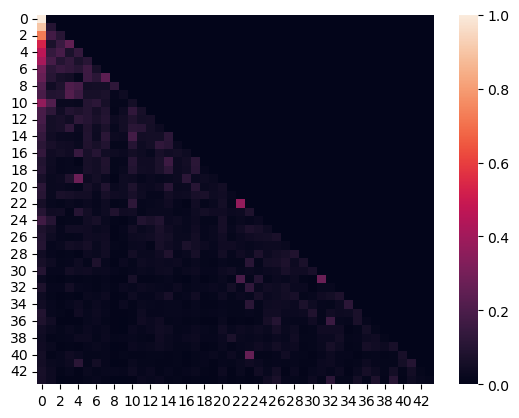

In [5]:
# The input to the model is a dictionary with the input ids and attention mask (the one returned by the tokenizer)
with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states

# The hidden states are a tuple of tensors. Each tensor corresponds to the output of each layer in the model. 
# The first tensor is the output of the embedding layer
embeddedTokensFirstLayer = hidden_states[0][0]
print(f"The initial embedding matrix is:")
print(embeddedTokensFirstLayer)
print("It's different from the one we computed before because positional encoding")

# Only get from the second layer to the last layer
layers = hidden_states[1:]
# attentions is a tuple of tensors. Each tensor is 12 attention maps of 16x16 matrices.
attentions = outputs.attentions

print(f"\nThis is an attention matrix from the first layer, the third head")
sns.heatmap(attentions[0][0][2])
plt.plot()

EVOLUTION OF TOKEN 40, namely ' Galileo'
I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. I was born in 1564 and died in 1642. My name is Galileo ...

LAYER 0 -----------------------------------
Expected: ' Galile'
Would have predicted at this layer:','
Cos angle: 0.066
 -> 0.11: ','
 -> 2.46: '-'
 -> 4.31: ' and'
 -> 6.14: '.'
 -> 6.59: ''s'
 -> 9.80: ' in'
 -> 10.76: ' the'
 -> 13.04: '
'
 -> 14.34: ' ('
 -> 14.92: ' to'

LAYER 1 -----------------------------------
Expected: ' Galile'
Would have predicted at this layer:','
Cos angle: 0.052
 -> 0.02: ','
 -> 4.32: ' and'
 -> 5.07: '-'
 -> 7.81: '.'
 -> 8.21: ''s'
 -> 12.27: ' in'
 -> 14.00: ' the'
 -> 16.92: '
'
 -> 16.99: ' ('
 -> 17.27: ' to'

LAYER 2 -----------------------------------
Expected: ' Galile'
Would have predicted at this layer:','
Cos angle: 0.040
 -> 0.00: ','
 -> 6.18: ' and'
 -> 8.96: '-'
 -> 10.03: '.'
 -> 11.56: ''s'
 -> 14.31: ' in'
 -> 15.84: ' the'
 -> 19

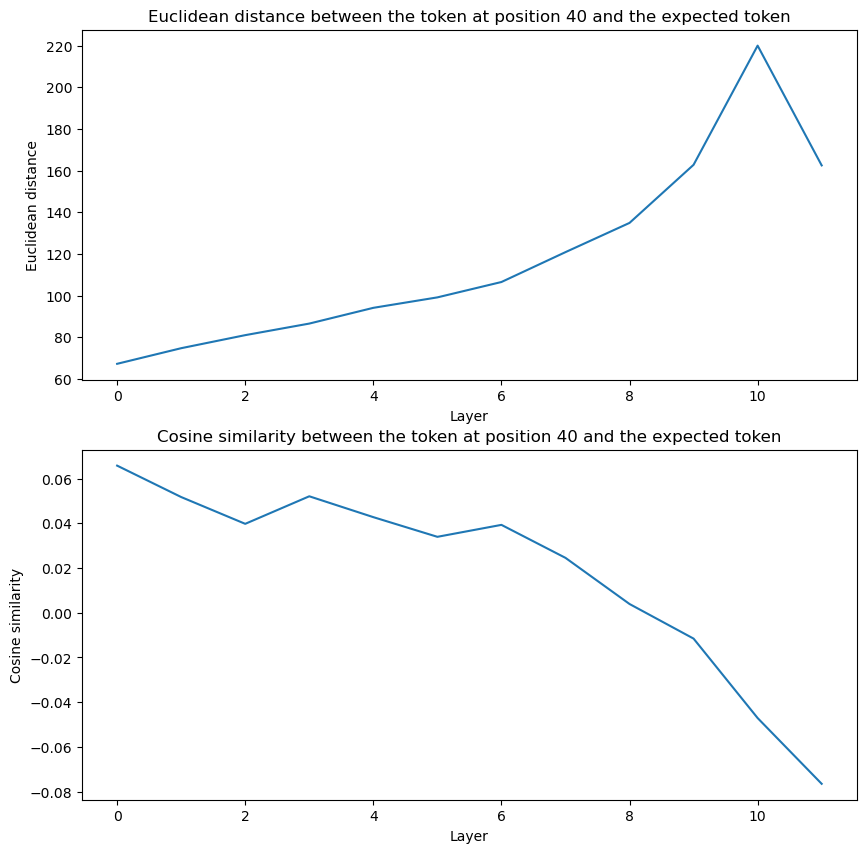

In [6]:
def get_tokens_prob(x, k=5):
    # Compute the similarity between the token and all the tokens in the vocabulary, then applies softmax
    prob = torch.softmax(torch.matmul(x,embeddings.T), dim=-1)
    # Get the top k tokens
    top = torch.topk(prob, k=k)
    idxs = top.indices
    tokens = [tokenizer.decode(idx) for idx in idxs]
    return top.values, idxs, tokens

X0 = layers[0][0]           # !!!!! X0 is not the initial embedding matrix, but the output of the first layer? Already soaked in w/ p.e. and context


traked_token = 40
print(f"EVOLUTION OF TOKEN {traked_token}, namely '{tokenizer.decode(encodedPrompt['input_ids'][0][traked_token])}'")
print(tokenizer.decode(inputs["input_ids"][0][:traked_token+1]), "...")

# embedding of the token at position traked_token+1 (to which the previous one should converge)
x_expected = embeddings[encodedPrompt["input_ids"][0][traked_token+1]] 

cosines=[]
euclideanDistances = []
# repeat for each layer
for i, layer in enumerate(layers):
    x = layer[0, traked_token]                                              # embedding of the token at position traked_token
    # compute the probs/logits starting from the selected token
    prob, idxs, tokens = get_tokens_prob(x, 10)
    print(f"\nLAYER {i} -----------------------------------")
    print(f"Expected: '{tokenizer.decode(encodedPrompt['input_ids'][0][traked_token+1])}'")
    print(f"Would have predicted at this layer:'{tokens[0]}'")
    cosine = torch.nn.functional.cosine_similarity(x, x_expected, dim=0)
    euclidean = torch.norm(x - x_expected)
    cosines.append(cosine)
    euclideanDistances.append(euclidean)
    print(f"Cos angle: {float(cosine):.3f}")
    for p, _, token in zip(prob, idxs, tokens):
        print(f" -> {-torch.log(p):.2f}: '{token}'")

max = -1.1
for emb in embeddings:
    if torch.nn.functional.cosine_similarity(x, emb, dim = -1) > max:
        max = torch.norm(torch.nn.functional.cosine_similarity(x, emb, dim = -1))
    
print(f"\nMax cosine similarity: {max:.3f}")
        


print("\n\n\n")
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(euclideanDistances)
ax[0].set_title("Euclidean distance between the token at position 40 and the expected token")
ax[0].set_xlabel("Layer")
ax[0].set_ylabel("Euclidean distance")

ax[1].plot(cosines)
ax[1].set_title("Cosine similarity between the token at position 40 and the expected token")
ax[1].set_xlabel("Layer")
ax[1].set_ylabel("Cosine similarity")

plt.show()

Pure generation

In [7]:
prompt = "I'm an Italian physicist who lived in Padua. I am known for my work in the field of optics and astronomy. I was born in 1564 and died in 1642. My name"
inputs = tokenizer(prompt, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states

layers = hidden_states[1:]
# attentions is a tuple of tensors. Each tensor is 12 attention maps of 16x16 matrices.
attentions = outputs.attentions


outputLayer = layers[-1][0]
nextToken = outputLayer[-1]
prob, idxs, tokens = get_tokens_prob(nextToken, 10)
print("Next token prediction:")
for p, _, token in zip(prob, idxs, tokens):
    print(f" -> {-torch.log(p):.2f}: '{token}'")


Next token prediction:
 -> 0.36: ' is'
 -> 2.13: ' was'
 -> 3.10: ' has'
 -> 4.43: ' means'
 -> 4.56: ' and'
 -> 4.57: ' comes'
 -> 4.82: ','
 -> 5.17: ' came'
 -> 5.29: ' appears'
 -> 5.45: ''s'
